# Linear Classifier Probes

This tutorial introduces Linear Classifier Probes, a useful tool for analyzing activations of hidden layers, following the ideas outlined in the paper [*Understanding intermediate layers
using linear classifier probes*](https://arxiv.org/pdf/1610.01644.pdf) by Alain & Bengio (2018).
The implementation relies on a subclass of the hooks and probe system already in `dltb`.

In this example, we will train linear classifier probes on every second layer of LeNet using the CIFAR-10 dataset in PyTorch.

## Loading the model

First, we need to load the model into a `dltb.Graph` representation, so we can attach our probe. The model was trained using [PyTorch's Training a classifier tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) and its weights exported.

After we have defined our architecture, we can load its weights from `"cifar_net.pth"`.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.linear_model import SGDClassifier

from dltb.pytorch import Graph

from probes import LinearClassifierProbe


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the network representation and load its weights    
net = Net()
net.load_state_dict(torch.load("./data/cifar_net.pth"))    

ModuleNotFoundError: No module named 'probes'

In [ ]:
# Convert the network to dltb.Graph
graph = Graph(net, input_shape=(3, 32, 32))
graph.summary()

+---------+------------------------------------+-------------+---------+
| name    | node type                          | param count | outputs |
+=========+====================================+=============+=========+
| x       | Input                              | 0           | conv1   |
| conv1   | Convolution                        | 456         | relu    |
| relu    | relu (function call)               | 0           | pool    |
| pool    | Pooling(method: max)               | 0           | conv2   |
| conv2   | Convolution                        | 2416        | relu_1  |
| relu_1  | relu (function call)               | 0           | pool_1  |
| pool_1  | Pooling(method: max)               | 0           | flatten |
| flatten | flatten (function call)            | 0           | fc1     |
| fc1     | Fully Connected(num_features: 120) | 48120       | relu_2  |
| relu_2  | relu (function call)               | 0           | fc2     |
| fc2     | Fully Connected(num_features: 84)  | 10

## Preparing the data

The CIFAR-10 dataset is conveniently provided to us using `torchvision`. We can load the training and testing data into the `trainloader` and `testloader` respectively, which will also apply normalization to the images.

Note: Depending on your network and dataset, you might need to resize the images when loading them, so they fit into the input the network expects.

In [ ]:

transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

BATCH_SIZE = 32

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


## Defining the linear classifier probe

A `LinearClassifierProbe` accepts a *classifier* as well as *classes* you want to predict. For now, keep the classifier needs to implement the `fit_partial()` method, but you can also export the layer activations beforehand, train your classifier on that data, and put the trained classifier into a LinearClassifierProbe.

Here we are using the SGDClassifier from scikit-learn with cross-entropy loss and a constant learning rate of 0.01.

Since the CIFAR-10 dataset consists of 10 classes, we can describe their one-hot-encoded version as an identity matrix of width and height 10.

To attach the probe, select the desired layer and use `add_probe()`. By default the probe will measure the layers output.


In [ ]:
# Starting at 1 to skip the input layer
LAYERS_TO_ATTACH = [i for i in range(1, 13)]

# Define an individual probe for each layer
probes = [LinearClassifierProbe(
    classifier=SGDClassifier(loss="log_loss", learning_rate="constant", eta0=0.01),
    classes = np.identity(10)
) for _ in LAYERS_TO_ATTACH]

# Attach the probe to the network
for probe, n_layer in zip(probes, LAYERS_TO_ATTACH):
    graph.nodes[n_layer].add_probe(probe)

## Training the classifier

Now that the probes are attached, we run through the training dataset to train our classifier probe. Each batch of data will train one step of gradient descent in the classifier. It is also important to provide the labels each batch because the original network is already pretrained and does not require the labels during the forward pass.

In [ ]:
for data in tqdm(trainloader, "Training"):
    input_images, input_labels = data

    for probe in probes:
        probe.labels = input_labels.numpy()

    graph.forward(input_images)

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

## Validation

The validation step for the probes is quite similar to the training step. We first set the mode of all probes from `"train"` to `"predict"`.

Then we run through the testing dataset the same way as before. The reason to provide the labels again is so that the probes can calculate their individual accuracy scores.

Afterward, we gather all the results in a bar diagram.

In [ ]:
# Change each probe into prediction mode
for probe in probes:
    probe.set_mode("predict")

# Run through the validation set
for data in tqdm(testloader, "Testing"):
    input_images, input_labels = data

    for probe in probes:
        probe.labels = input_labels.numpy()

    graph.forward(input_images)

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

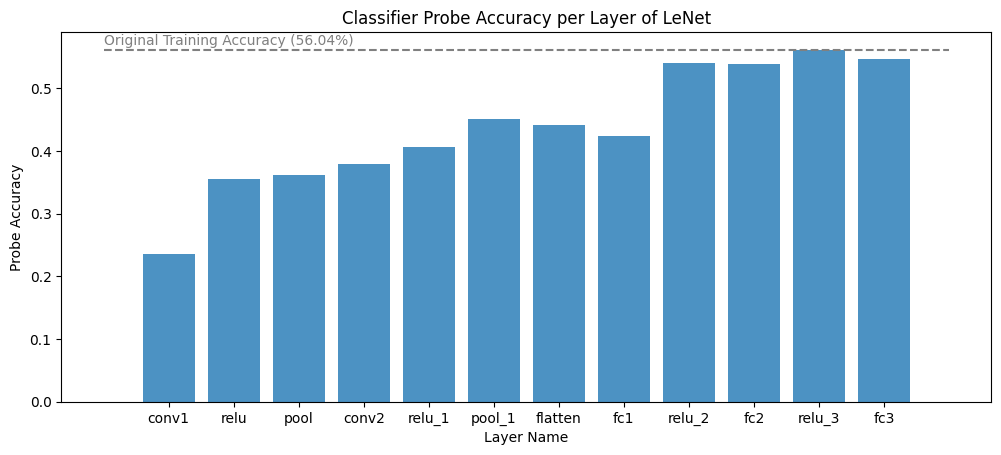

In [ ]:
fig, ax = plt.subplots()
fig.set_figwidth(12)

ax.bar([probe.name for probe in probes], [probe.accuracy for probe in probes], alpha=0.8)

ax.set_ylabel("Probe Accuracy")
ax.set_xlabel("Layer Name")
ax.set_title("Classifier Probe Accuracy per Layer of LeNet")
ax.hlines(y=0.5604, xmin=-1, xmax=len(probes), linestyle="dashed", color="gray")
ax.annotate("Original Training Accuracy (56.04%)", xy=(-1, 0.57), color="gray")

plt.show()